In [1]:
# Bibliothek für mehr-D Daten (speziell für NetCDF-Daten; Zeit, geografische Koordinaten, ...)
import xarray as xr
import dask

import numpy as np
from matplotlib import pyplot as plt

import cartopy.crs as ccrs

In [2]:
## Auswahl der Daten
# https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_ENS_001_031/services

# xr.open_dataset = Funktion, um Datensatz im NetDCF-Format öffnen
ds_ssh = xr.open_dataset(
    "../data/adt_5d.nc",
    # aktiviert Lazy-Loading mit Bibliothek Dask
    # Dask teilt Datensatz in kleinere Chunks auf, die nur bei Bedarf geladen werden in Arbeitsspeicher
    chunks="auto",
)
# Funktion von xarray.Dataset rename
ds_ssh = ds_ssh.rename_vars(adt="sea_surface_height")

ds_ssh = ds_ssh.rename({'latitude': 'lat', 'longitude': 'lon'})

# Übersicht des Datensatz wird angezeigt
ds_ssh

<xarray.Dataset> Size: 3GB
Dimensions:             (lat: 240, lon: 1440, time: 2327)
Coordinates:
  * lat                 (lat) float32 960B -89.88 -89.62 ... -30.38 -30.12
  * lon                 (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time                (time) datetime64[ns] 19kB 1993-01-01 ... 2024-11-04
Data variables:
    sea_surface_height  (time, lat, lon) float32 3GB dask.array<chunksize=(808, 83, 499), meta=np.ndarray>

In [3]:
#testen
#test_ssh=ds_ssh.sea_surface_height.isel( lat=230,lon=1000)
#test_ssh.plot()
#test_ssh.values

In [5]:
## Filterzeitraum definieren

start_date = '1999-11-01'
end_date = '2023-12-01'

# Filter anwenden
gefilterte_ssh = ds_ssh.sel(time=slice(start_date, end_date))

# Gefilterte Daten speichern
output_path = "../data/gefilterte_ssh.nc"
gefilterte_ssh.to_netcdf(output_path)
print(f"Gefilterte SSH-Daten wurden in {output_path} gespeichert.")

gefilterte_ssh.values()

Gefilterte SSH-Daten wurden in ../data/gefilterte_ssh.nc gespeichert.


ValuesView(<xarray.Dataset> Size: 2GB
Dimensions:             (lat: 240, lon: 1440, time: 1760)
Coordinates:
  * lat                 (lat) float32 960B -89.88 -89.62 ... -30.38 -30.12
  * lon                 (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time                (time) datetime64[ns] 14kB 1999-11-01 ... 2023-11-30
Data variables:
    sea_surface_height  (time, lat, lon) float32 2GB dask.array<chunksize=(309, 83, 499), meta=np.ndarray>)

In [6]:
#testen
#test_ssh=gefilterte_ssh.sea_surface_height.isel( lat=230,lon=1000)
#test_ssh.plot()
#test_ssh.values

In [7]:
## Höhenanomalie berechnen

# Zeitlicher Mittelwert
ssh_mean = gefilterte_ssh['sea_surface_height'].mean(dim="time")
# Anomalie von SSH
ssh_anomaly = gefilterte_ssh['sea_surface_height'] - ssh_mean

print(ssh_mean)
print(ssh_anomaly)

<xarray.DataArray 'sea_surface_height' (lat: 240, lon: 1440)> Size: 1MB
dask.array<mean_agg-aggregate, shape=(240, 1440), dtype=float32, chunksize=(83, 499), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 960B -89.88 -89.62 -89.38 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
<xarray.DataArray 'sea_surface_height' (time: 1760, lat: 240, lon: 1440)> Size: 2GB
dask.array<sub, shape=(1760, 240, 1440), dtype=float32, chunksize=(808, 83, 499), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 960B -89.88 -89.62 -89.38 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) datetime64[ns] 14kB 1999-11-01 1999-11-06 ... 2023-11-30


In [8]:
#testen
#test_ssh=ssh_mean.isel( lat=230)
#test_ssh.plot()
#test_ssh.values

In [9]:
#testen
#test_ssh=ssh_anomaly.isel( lat=230, lon=1000)
#test_ssh.plot()
#test_ssh.values

In [10]:
## Horizontale Ableitung für geostrophische Geschwindigkeiten

# Umbennen der Dimension
# gefilterte_ssh = gefilterte_ssh.rename({'latitude': 'lat', 'longitude': 'lon'})

# Schwerebeschleunigung und Coriolisparameter definieren
g = 9.81  # m/s²
f_coriolis = 2 * 7.2921e-5 * np.sin(np.radians(gefilterte_ssh.lat))  # f = 2 * Omega * sin(lat)

# Symmetrische Ableitung (finite differences) für Gradient der SSH-Anomalie
# Abstand in m (abhängig von Breite) (dy in NS-Richtung, dx in OW-Richtung), Entfernung 2 Breitengrade ist const ~111km (=1°=60sm=1lat), Längengrade abhängig von Breite
dy, dx = 111e3, 111e3 * np.cos(np.radians(gefilterte_ssh.lat))
# mit .differentiate Gradient berechnen und /dx und /dy für Konventierung pro Grad in pro Meter
ssh_anomaly_dx = ssh_anomaly.differentiate(coord='lon') / dx
ssh_anomaly_dy = ssh_anomaly.differentiate(coord='lat') / dy # dy = 111e3

# Geostrophische Geschwindigkeitsanomalien berechnen
u_anomaly = -(g / f_coriolis) * ssh_anomaly_dy # Dimensionen = ('latitude', 'time', 'longitude')
v_anomaly = (g / f_coriolis) * ssh_anomaly_dx # Dimensionen = ('latitude', 'time', 'longitude')

# print(u_anomaly.values)

In [11]:
#testen
#test_ssh=u_anomaly.isel( lat=230, lon=1000)
#test_ssh.plot()
#test_ssh.values

In [12]:
#testen
#test_ssh=v_anomaly.isel( lat=230, lon=1000)
#test_ssh.plot()
#test_ssh.values

In [13]:
## zeitliche Standardabweichung der u und v Anomalie mit linearer Skala plotten
# -> hohe Std = hohe Variabilität (zb. intensive Wirbelbildung)

# Std berechnen = wie stark sie um Mittelwert streuen an jeder räumlichen Position
u_std = np.std(u_anomaly, axis=1) # über 1. Achse der Dimension durchführen -> Zeit, dh wie stark Anomalie an jeder räumlichen Position (Breite/Länge) im Zeitverlauf variieren, dh jz nur noch 2 Dim übrig -> lat und lon
v_std = np.std(v_anomaly, axis=1)

print(u_std.dims)

# Extrahieren der Koordinaten aus dem Dataset
lat = gefilterte_ssh['lat'].values  # Wandelt die xarray-Koordinate in ein Numpy-Array um
lon = gefilterte_ssh['lon'].values

# Plot der Standardabweichung mit linearer Skala
#plt.figure(figsize=(12, 6))
# u-Anomalie Plot
#plt.subplot(2, 1, 1)
#plt.title('Standardabweichung u-Anomalie')
#plt.imshow(u_std, origin='lower', aspect='auto', 
#           extent=[lon.min(), lon.max(), lat.min(), lat.max()])
#plt.colorbar(label='Standardabweichung')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')

# v-Anomalie Plot
#plt.subplot(2, 1, 2)
#plt.title('Standardabweichung v-Anomalie')
#plt.imshow(v_std, origin='lower', aspect='auto', 
#           extent=[lon.min(), lon.max(), lat.min(), lat.max()])
#plt.colorbar(label='Standardabweichung')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')

#plt.tight_layout()
#plt.show()

('lat', 'lon')


In [14]:
# da Fehlermeldung, hier werden nun doppelte Werte in time-Dim entfernt
#u_anomaly = u_anomaly.sel(time=~u_anomaly.get_index("time").duplicated())
#v_anomaly = v_anomaly.sel(time=~v_anomaly.get_index("time").duplicated())

#duplicates = u_anomaly.get_index("time")[u_anomaly.get_index("time").duplicated()]
#print("Doppelte Werte in u_anomaly:", duplicates) --> NONE

#duplicates = v_anomaly.get_index("time")[v_anomaly.get_index("time").duplicated()]
#print("Doppelte Werte in v_anomaly:", duplicates) --> NONE


In [15]:
## EKE berechnen
# Reynoldsmittelnung (nicht mit Prinzip El.Technik von Hochpass, Tiefpass, Bandpass)

time_window = 90 # in d
# u-Richtung
ubar = u_anomaly.coarsen(time=time_window, boundary='trim').mean() # has 90d resolution, coarsen ~ vergroebern, boundary = trim = abschneiden, sodass Daten ohne Rest
uprime = u_anomaly - ubar.interp_like(u_anomaly, method="nearest") # daily resolution, mit reindex_like Fehler
# v-Richtung
vbar = v_anomaly.coarsen(time=time_window, boundary='trim').mean() # has 90d resolution, coarsen ~ vergroebern, boundary = trim = abschneiden, sodass Daten ohne Rest
vprime = v_anomaly - vbar.interp_like(v_anomaly, method="nearest") # daily resolution

eke_bar = 0.5 * ((uprime ** 2).coarsen(time=time_window, boundary='trim').mean() + (vprime ** 2).coarsen(time=time_window, boundary='trim').mean()) # 90d resolution of EKE_bar: 1/2 * (u'^2 + v'^2)  

print(eke_bar)
print(uprime.values)

<xarray.DataArray (lat: 240, time: 19, lon: 1440)> Size: 26MB
dask.array<mul, shape=(240, 19, 1440), dtype=float32, chunksize=(83, 7, 499), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 960B -89.88 -89.62 -89.38 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) datetime64[ns] 152B 2000-06-10T12:00:00 ... 2022-08-14T12...
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan .

In [16]:
#testen
#test_ssh=eke_bar.isel( lat=230, lon=1000)
#test_ssh.plot()
#test_ssh.values

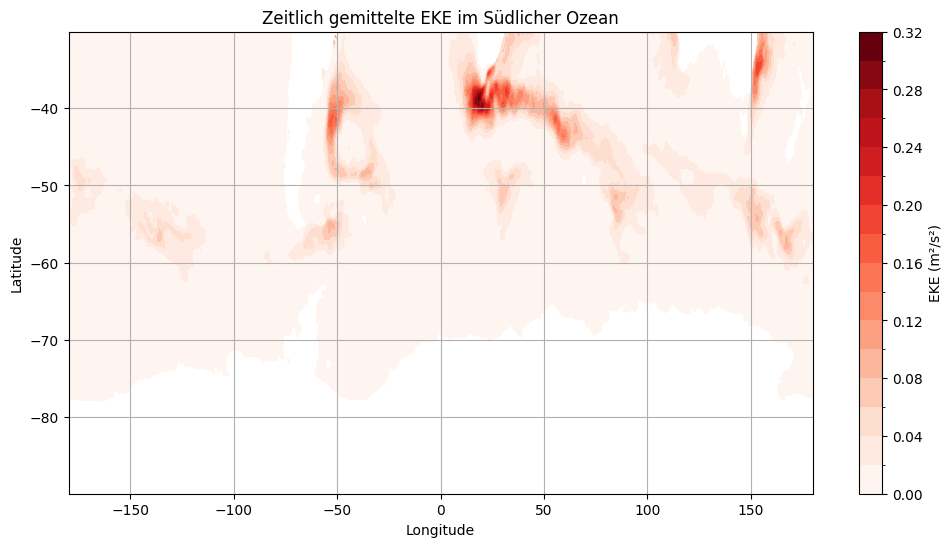

In [17]:
# plotten ohne Masken und Gewichtung

## EKE plotten

# Sicherstellen, dass alle Dimensionen korrekt verarbeitet werden
# Mitteln über die Zeit (zeitliche Mittelung), falls noch nicht geschehen
eke_time_mean = eke_bar.mean(dim='time')

# Plot 1: Zeitlich gemittelte EKE
plt.figure(figsize=(12, 6))
eke_time_mean.plot.contourf(levels=20, cmap='Reds', cbar_kwargs={'label': 'EKE (m²/s²)'})
plt.title("Zeitlich gemittelte EKE im Südlicher Ozean")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

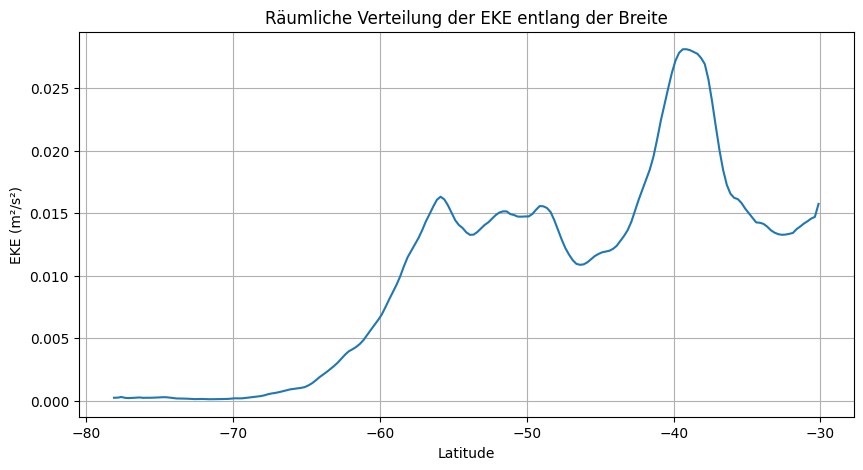

In [18]:
# Plot 2: Räumliche Verteilung der EKE entlang der Breite
eke_lat_mean = eke_bar.mean(dim=['lon', 'time'])  # Mittelung über Länge und Zeit

plt.figure(figsize=(10, 5))
eke_lat_mean.plot()
plt.title("Räumliche Verteilung der EKE entlang der Breite")
plt.xlabel("Latitude")
plt.ylabel("EKE (m²/s²)")
plt.grid()
plt.show()

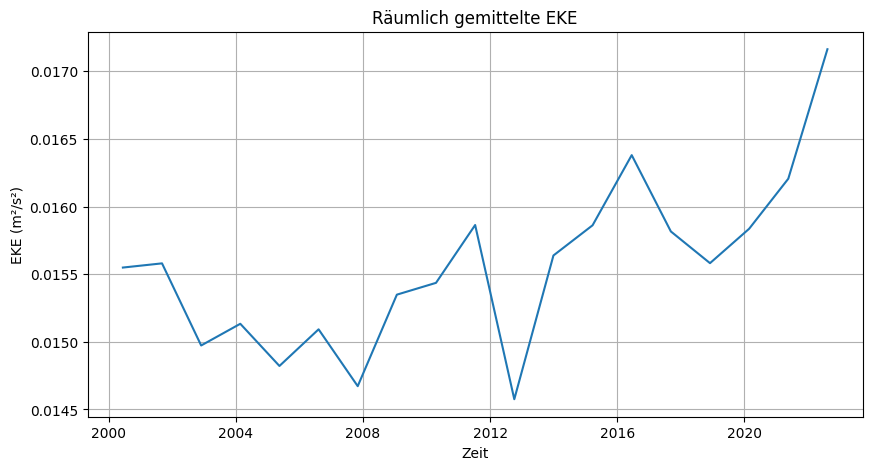

In [37]:
# Plot 3: Räumlich gemittelte EKE

eke_year_mean = eke_bar.where(-30>eke_bar.lat)
eke_year_mean_2=eke_year_mean.where(eke_year_mean.lat>-60).mean(dim=['lon', 'lat'])  # Mittelung über Länge und Breite

plt.figure(figsize=(10, 5))
eke_year_mean_2.plot()
plt.title("Räumlich gemittelte EKE")
plt.xlabel("Zeit")
plt.ylabel("EKE (m²/s²)")
plt.grid()
plt.show()

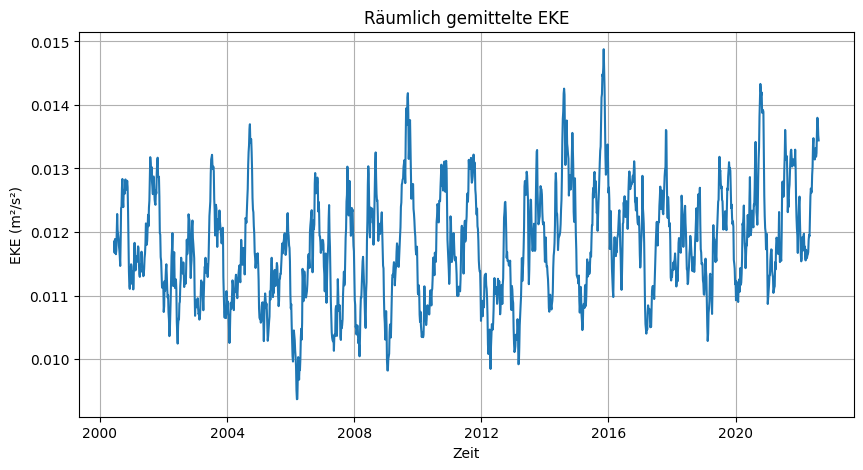

In [23]:
# Plot 3: Räumlich gemittelte EKE
eke_year_mean = (uprime**2).mean(dim=['lon', 'lat'])  # Mittelung über Länge und Breite

plt.figure(figsize=(10, 5))
eke_year_mean.plot()
plt.title("Räumlich gemittelte EKE")
plt.xlabel("Zeit")
plt.ylabel("EKE (m²/s²)")
plt.grid()
plt.show()

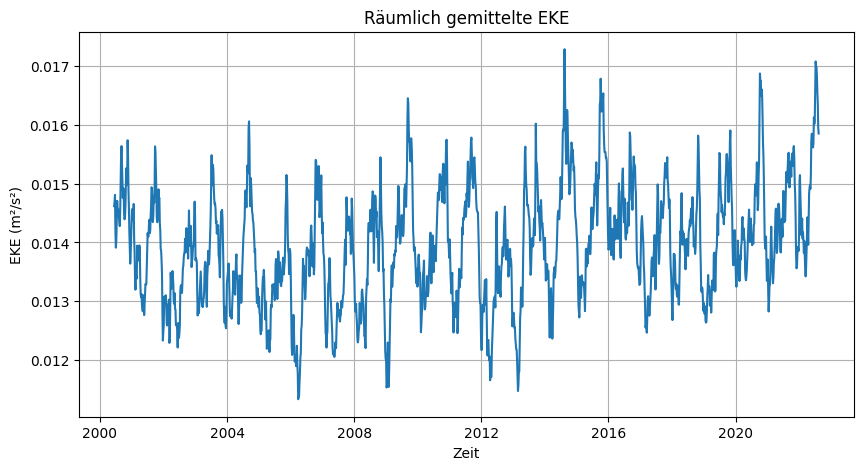

In [24]:
# Plot 3: Räumlich gemittelte EKE
eke_year_mean = (vprime**2).mean(dim=['lon', 'lat'])  # Mittelung über Länge und Breite

plt.figure(figsize=(10, 5))
eke_year_mean.plot()
plt.title("Räumlich gemittelte EKE")
plt.xlabel("Zeit")
plt.ylabel("EKE (m²/s²)")
plt.grid()
plt.show()

In [ ]:
print(eke_bar)
print(eke_bar.isnull().sum())

print(eke_bar.time)  # Zeigt alle verbleibenden Zeitpunkte
print(len(eke_bar.time))  # Anzahl der Zeitpunkte

In [ ]:
## Masken erstellen

# Zeitliche Maske -> Sommerzeit
summer_months = [12, 1, 2]  # Dezember bis Februar
summer_mask = gefilterte_ssh['time.month'].isin(summer_months)

# Maske anwenden, um gültige Punkte basierend auf Sommerdaten zu extrahieren
ssh_summer = gefilterte_ssh['sea_surface_height'].where(summer_mask)

# 3. Räumliche Maske erstellen: Gültigkeit über die Zeit aggregieren
valid_mask = ssh_summer.notnull().any(dim="time")  # Aggregation über 'time'

# 4. Maske anwenden (optional): Nur gültige Punkte behalten
ds_summer = gefilterte_ssh.where(valid_mask)

# Dim prüfen
print("Dimensionen von summer_mask:", summer_mask.dims)  # 'time'
print("Dimensionen von valid_mask:", valid_mask.dims)    # 'lat', 'lon'

In [ ]:
## Gewichtung durch cos(lat) und Fläche

cos_lat = np.cos(np.radians(ds_summer['lat']))
area_weights = cos_lat * valid_mask  # Maske berücksichtigt gültige Werte (z. B. Sommer, eisfrei)

print(area_weights)
print("Dimensionen area_weights",area_weights.dims)

In [ ]:
## Mittelungen bzgl Gitterboxgröße

# 1. Globale gewichtete Mittelung
eke_global_mean = (eke * area_weights).sum(dim=['lat', 'lon']) / area_weights.sum(dim=['lat', 'lon'])
print("Global gewichtetes EKE (über Fläche):", eke_global_mean.values)

# 2. Räumliche Mittelung (pro Breitengrad)

# 2.1 Normierungsfaktor basierend auf cos(lat)
cos_lat_sum = (cos_lat * valid_mask).sum(dim='lat')  # Normierung entlang lat

# 2.2 Mittelung der EKE entlang der Längengrade (lon)
eke_mean_lon = eke.mean(dim='lon')  # Reduktion der Dimension 'lon'

# 2.3 Gewichtete Mittelung entlang der Breiten
eke_lat_mean = (eke_mean_lon * cos_lat).sum(dim='lat') / cos_lat.sum()

# Prüfen der Dimensionen
print("Dimensionen von eke_lat_mean:", eke_lat_mean.dims)

In [ ]:
## EKE über SO mitteln

# Südlicher Ozean: Breite -60° bis -30°
eke_southern_ocean = eke.sel(lat=slice(-60, -30)).mean(dim=['lat', 'lon'])

In [ ]:
## EKE plotten

# Sicherstellen, dass nur über die Zeit gemittelt wird, nicht über andere Dimensionen
eke_time_mean_masked = (eke * area_weights).mean(dim='time')
# HIER EKE BENUTZT UND NICHT MASKIERTE WERTE

plt.figure(figsize = (12, 6))
eke_time_mean_masked.plot.contourf(levels=20, cmap='Reds', cbar_kwargs={'label': 'EKE (m²/s²)'})
plt.title("Gewichtete und maskierte EKE (im Sommer, eisfrei) im Südlicher Ozean")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

# Räumliche Verteilung der EKE entlang der Breite
plt.figure(figsize=(10, 5))
eke_lat_mean.plot()
plt.title("Räumliche Verteilung der EKE entlang der Breite")
plt.xlabel("Latitude")
plt.ylabel("EKE (normiert)")
plt.grid()
plt.show()

# Langfristige und regionale Variabilität der EKE
#eke_time_series = eke_southern_ocean.mean(dim=['latitude', 'longitude'])
#print(eke_time_series.dims)


#plt.figure(figsize=(12, 6))
#eke_time_series.plot()
#plt.title("Zeitliche Variabilität der Eddy Kinetischen Energie (Südlicher Ozean")
#plt.xlabel("Zeit")
#plt.ylabel("EKE (m²/s²)")
#plt.grid()
#plt.show()

In [ ]:
## Plotting EKE

# Ensure that averaging is done only over time, not other dimensions
eke_time_mean_masked = (eke * area_weights).mean(dim='time')
# USE EKE AND NOT MASKED VALUES

plt.figure(figsize = (12, 6))
eke_time_mean_masked.plot.contourf(levels=20, cmap='Reds', cbar_kwargs={'label': 'EKE (m²/s²)'})
plt.title("Weighted and Masked EKE (Summer, Ice-free) in the Southern Ocean")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

# Spatial distribution of EKE along latitude
plt.figure(figsize=(10, 5))
eke_lat_mean.plot()
plt.title("Spatial Distribution of EKE along Latitude")
plt.xlabel("Latitude")
plt.ylabel("EKE (normalized)")
plt.grid()
plt.show()

# Long-term and regional variability of EKE
#eke_time_series = eke_southern_ocean.mean(dim=['latitude', 'longitude'])
#print(eke_time_series.dims)


#plt.figure(figsize=(12, 6))
#eke_time_series.plot()
#plt.title("Temporal Variability of Eddy Kinetic Energy (Southern Ocean)")
#plt.xlabel("Time")
#plt.ylabel("EKE (m²/s²)")
#plt.grid()
#plt.show()


In [ ]:
## Graphics for Oceanografia Fisica Aplicada

import numpy as np
import matplotlib.pyplot as plt

# Define the time periods (1998-2000 and 2001-2003)
time_period_1 = (eke.time.dt.year >= 1998) & (eke.time.dt.year <= 2000)
time_period_2 = (eke.time.dt.year >= 2001) & (eke.time.dt.year <= 2003)

# Calculate the EKE for the period 1998-2000
eke_time_mean_masked_1998_2000 = (eke.sel(time=time_period_1) * area_weights).mean(dim='time')

# Calculate the EKE for the period 2001-2003
eke_time_mean_masked_2001_2003 = (eke.sel(time=time_period_2) * area_weights).mean(dim='time')

# Plot for the period 1998-2000
plt.figure(figsize=(12, 6))
eke_time_mean_masked_1998_2000.plot.contourf(levels=20, cmap='Reds', cbar_kwargs={'label': 'EKE (m²/s²)'})
plt.title("EKE (1998-2000) in the Southern Ocean")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

# Plot for the period 2001-2003
plt.figure(figsize=(12, 6))
eke_time_mean_masked_2001_2003.plot.contourf(levels=20, cmap='Reds', cbar_kwargs={'label': 'EKE (m²/s²)'})
plt.title("EKE (2001-2003) in the Southern Ocean")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

# Spatial distribution of EKE along latitude for the period 1998-2000
eke_lat_mean_1998_2000 = eke_time_mean_masked_1998_2000.mean(dim='longitude')
plt.figure(figsize=(10, 5))
eke_lat_mean_1998_2000.plot()
plt.title("Spatial Distribution of EKE along Latitude (1998-2000)")
plt.xlabel("Latitude")
plt.ylabel("EKE (normalized)")
plt.grid()
plt.show()

# Spatial distribution of EKE along latitude for the period 2001-2003
eke_lat_mean_2001_2003 = eke_time_mean_masked_2001_2003.mean(dim='longitude')
plt.figure(figsize=(10, 5))
eke_lat_mean_2001_2003.plot()
plt.title("Spatial Distribution of EKE along Latitude (2001-2003)")
plt.xlabel("Latitude")
plt.ylabel("EKE (normalized)")
plt.grid()
plt.show()


In [ ]:
# 1. Räumliche Mittelung der EKE
eke_time_series = (eke * area_weights).mean(dim=('lat', 'lon'))

# 2. Normierung der EKE-Werte
eke_time_series_normed = eke_time_series / eke_time_series.max()

# 3. Plot der normierten Zeitreihe
plt.figure(figsize=(10, 5))
eke_time_series_normed.plot(color='blue', label='Normierte EKE')
plt.title("Entwicklung der normierten EKE über die Jahre")
plt.xlabel("Jahre")
plt.ylabel("Normierte EKE")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Orthographischen Projektion
plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Orthographic(0,-90))
ax.coastlines() # Küstenlinie hinzufügen
ax.gridlines() # Gitternetz hinzufügen
# Beschriftung
plt.title("Gewichtete und maskierte EKE (im Sommer, eisfrei) im Südlicher Ozean")
# Visualiserung der Daten
eke_time_mean_masked.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0.0, vmax=1.0, levels=20, cbar_kwargs={'label': 'EKE (m²/s²)'}, cmap='Reds')
ax.set_global()
plt.show()


In [ ]:
# Orthographischen Projektion mit Hervorherbung starken Gebieten (max. Wert = 0.87)
plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Orthographic(0,-90))
ax.coastlines() # Küstenlinie hinzufügen
ax.gridlines() # Gitternetz hinzufügen
# Logarithmische Farbskala
norm = colors.LogNorm(vmin=0.001, vmax=1.0)  # Werte zwischen 0.001 und 1.0, Log-Skala
# Beschriftung
plt.title("Gewichtete und maskierte EKE (im Sommer, eisfrei) im Südlicher Ozean")
# Visualiserung der Daten
eke_time_mean_masked.plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm, cmap='Reds', cbar_kwargs={'label': 'EKE (m²/s²)'})
ax.set_global()
plt.show()
